# Evaluation Visualization

This notebook loads data from `evaluation_summary.csv`, `evaluation_results.csv`, and `evaluation_run.csv` and visualizes retrieval performance over time and across methods/query types.

In [19]:
from __future__ import annotations

import csv
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')
# Resolve evaluation CSV directory regardless of launch directory.
DATA_DIR_CANDIDATES = [Path('.'), Path('evaluation'), Path('../evaluation')]
DATA_DIR = next((p for p in DATA_DIR_CANDIDATES if (p / 'evaluation_summary.csv').exists()), Path('.'))

def load_mixed_csv(path: Path) -> pd.DataFrame:
    rows = []
    current_header = None
    with path.open('r', encoding='utf-8', newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            if not row:
                continue
            row = [cell.strip() for cell in row]
            if row[0] in {'average_rank', 'query_type', 'doc_id'}:
                current_header = row
                continue
            if current_header is None:
                continue
            if len(row) < len(current_header):
                row = row + [''] * (len(current_header) - len(row))
            row = row[:len(current_header)]
            rows.append(dict(zip(current_header, row)))
    df = pd.DataFrame(rows)
    if not df.empty:
        # Drop any accidental repeated header rows that slipped through.
        df = df[df.iloc[:, 0] != df.columns[0]]
    return df

def pick_time_col(df: pd.DataFrame) -> str | None:
    for col in ('evaluated_at_cet', 'evaluated_at_utc', 'evaluated_at'):
        if col in df.columns:
            return col
    return None

def pick_method_col(df: pd.DataFrame) -> str | None:
    for col in ('method', 'search_method'):
        if col in df.columns:
            return col
    return None


In [20]:
summary_df = load_mixed_csv(DATA_DIR / 'evaluation_summary.csv')
results_df = load_mixed_csv(DATA_DIR / 'evaluation_results.csv')
run_df = load_mixed_csv(DATA_DIR / 'evaluation_run.csv')

for numeric_col in ('average_rank', 'average_score', 'RR@20', 'score', 'top_k', 'num_queries_total', 'num_query_types'):
    if numeric_col in summary_df.columns:
        summary_df[numeric_col] = pd.to_numeric(summary_df[numeric_col], errors='coerce')
    if numeric_col in results_df.columns:
        results_df[numeric_col] = pd.to_numeric(results_df[numeric_col], errors='coerce')
    if numeric_col in run_df.columns:
        run_df[numeric_col] = pd.to_numeric(run_df[numeric_col], errors='coerce')

summary_time_col = pick_time_col(summary_df)
results_time_col = pick_time_col(results_df)
run_time_col = pick_time_col(run_df)

if summary_time_col:
    summary_df['evaluated_at'] = pd.to_datetime(summary_df[summary_time_col], errors='coerce')
if results_time_col:
    results_df['evaluated_at'] = pd.to_datetime(results_df[results_time_col], errors='coerce')
if run_time_col:
    run_df['evaluated_at'] = pd.to_datetime(run_df[run_time_col], errors='coerce')

summary_method_col = pick_method_col(summary_df)
results_method_col = pick_method_col(results_df)
run_method_col = pick_method_col(run_df)

if summary_method_col:
    summary_df['method_name'] = summary_df[summary_method_col].fillna('').replace('', 'unknown')
else:
    summary_df['method_name'] = 'unknown'

if results_method_col:
    results_df['method_name'] = results_df[results_method_col].fillna('').replace('', 'unknown')
else:
    results_df['method_name'] = 'unknown'

if run_method_col:
    run_df['method_name'] = run_df[run_method_col].fillna('').replace('', 'unknown')
else:
    run_df['method_name'] = 'unknown'

print('summary_df:', summary_df.shape, 'columns:', list(summary_df.columns))
print('results_df:', results_df.shape, 'columns:', list(results_df.columns))
print('run_df:', run_df.shape, 'columns:', list(run_df.columns))
summary_df.head(3)

summary_df: (3, 10) columns: ['average_rank', 'average_score', 'evaluated_at_cet', 'top_k', 'num_queries_total', 'num_query_types', 'method', 'experiment', 'evaluated_at', 'method_name']
results_df: (28, 11) columns: ['query_type', 'RR@20', 'average_rank', 'evaluated_at_cet', 'top_k', 'num_queries_total', 'num_query_types', 'method', 'experiment', 'evaluated_at', 'method_name']
run_df: (4289, 12) columns: ['doc_id', 'query_id', 'score', 'query_type', 'evaluated_at_cet', 'top_k', 'num_queries_total', 'num_query_types', 'method', 'experiment', 'evaluated_at', 'method_name']


,average_rank,average_score,evaluated_at_cet,top_k,num_queries_total,num_query_types,method,experiment,evaluated_at,method_name
0,3.542857,0.436662,2026-02-17T17:35:51+01:00,20,13,7,dense_e5,NaN,2026-02-17 17:35:51+01:00,dense_e5
1,3.325974,0.504011,2026-02-18T12:27:26+01:00,20,13,7,hybrid_e5,hybrid_e5,2026-02-18 12:27:26+01:00,hybrid_e5
2,2.509524,0.460525,2026-02-18T12:57:45+01:00,20,13,7,bm25,bm25_baseline,2026-02-18 12:57:45+01:00,bm25


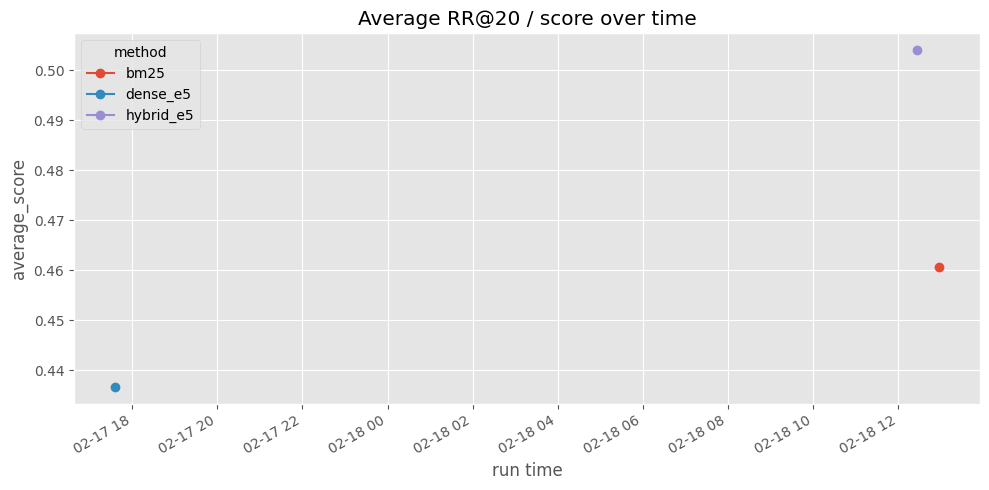

In [21]:
# 1) Average score over time
plot_df = summary_df.dropna(subset=['average_score']).copy()
if 'evaluated_at' in plot_df.columns:
    plot_df = plot_df.sort_values('evaluated_at')

fig, ax = plt.subplots(figsize=(10, 5))
for method, group in plot_df.groupby('method_name'):
    x = group['evaluated_at'] if 'evaluated_at' in group.columns else range(len(group))
    ax.plot(x, group['average_score'], marker='o', label=method)

ax.set_title('Average RR@20 / score over time')
ax.set_ylabel('average_score')
ax.set_xlabel('run time')
if plot_df['method_name'].nunique() > 1:
    ax.legend(title='method')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

,method_name,average_score,average_rank,evaluated_at_cet
0,bm25,0.460525,2.509524,2026-02-18T12:57:45+01:00
1,dense_e5,0.436662,3.542857,2026-02-17T17:35:51+01:00
2,hybrid_e5,0.504011,3.325974,2026-02-18T12:27:26+01:00


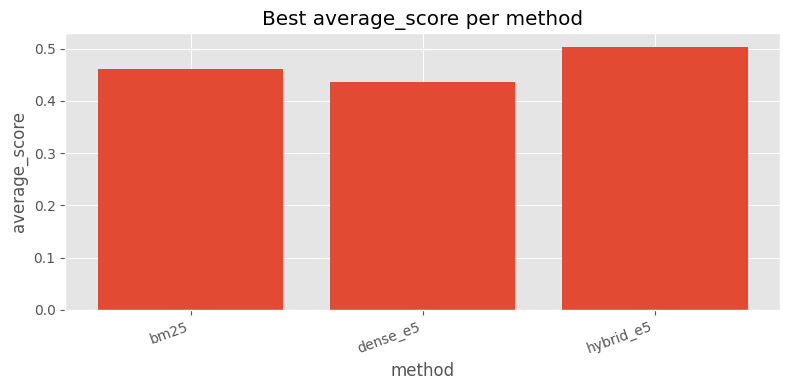

In [22]:
# 2) Best run per method (summary view)
best_per_method = (
    summary_df.dropna(subset=['average_score'])
    .sort_values('average_score', ascending=False)
    .groupby('method_name', as_index=False)
    .first()
)

display(best_per_method[['method_name', 'average_score', 'average_rank'] + ([summary_time_col] if summary_time_col else [])])

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(best_per_method['method_name'], best_per_method['average_score'])
ax.set_title('Best average_score per method')
ax.set_ylabel('average_score')
ax.set_xlabel('method')
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()

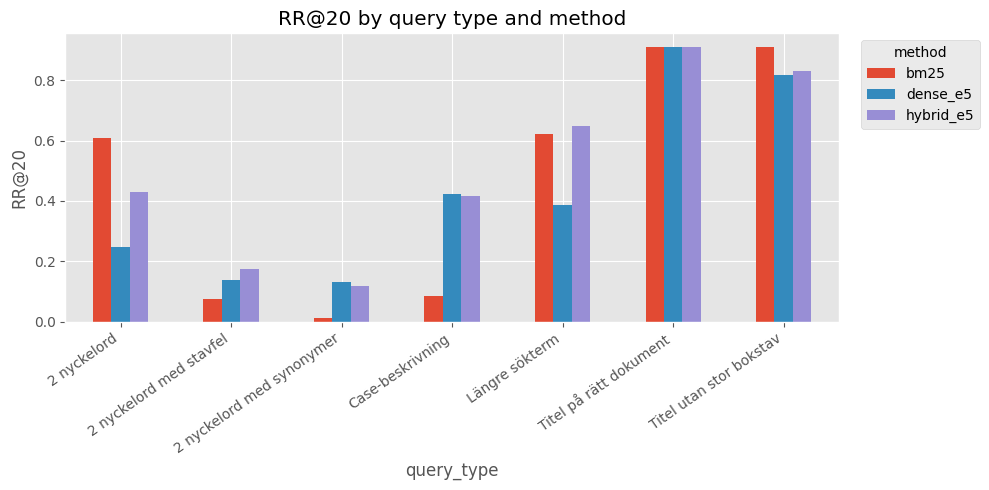

In [23]:
# 3) Query-type RR@20 profile
if results_df.empty:
    print('No rows in evaluation_results.csv')
else:
    results_plot_df = results_df.dropna(subset=['RR@20']).copy() if 'RR@20' in results_df.columns else results_df.copy()

    if 'method_name' in results_plot_df.columns and results_plot_df['method_name'].nunique() > 1:
        pivot = results_plot_df.pivot_table(
            index='query_type',
            columns='method_name',
            values='RR@20',
            aggfunc='mean'
        ).sort_index()

        fig, ax = plt.subplots(figsize=(10, 5))
        pivot.plot(kind='bar', ax=ax)
        ax.set_title('RR@20 by query type and method')
        ax.set_ylabel('RR@20')
        ax.set_xlabel('query_type')
        ax.legend(title='method', bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.xticks(rotation=35, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        # Fallback: visualize latest run (or full file if run timestamp missing)
        latest = results_plot_df
        if 'evaluated_at' in results_plot_df.columns:
            max_ts = results_plot_df['evaluated_at'].max()
            latest = results_plot_df[results_plot_df['evaluated_at'] == max_ts]

        latest = latest.sort_values('RR@20', ascending=False)
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(latest['query_type'], latest['RR@20'])
        ax.set_title('RR@20 by query type (latest run)')
        ax.set_ylabel('RR@20')
        ax.set_xlabel('query_type')
        plt.xticks(rotation=35, ha='right')
        plt.tight_layout()
        plt.show()

/tmp/ipykernel_35513/774350618.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(series, labels=methods, showfliers=False)


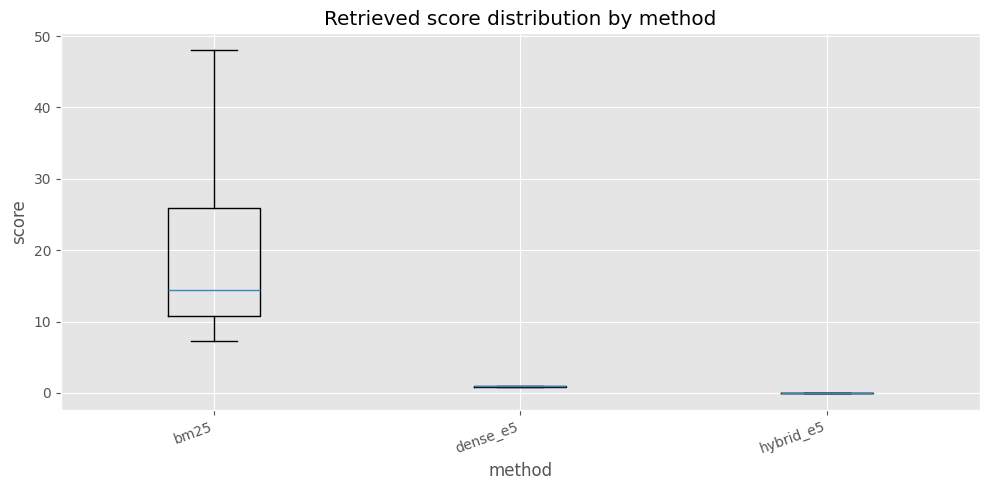

,method_name,count,mean,median,max
0,bm25,848,18.535976,14.449901,69.798470
1,dense_e5,1621,0.908969,0.909174,1.000000
2,hybrid_e5,1820,0.017471,0.015385,0.032787


In [24]:
# 4) Run-level score distributions by method
if run_df.empty or 'score' not in run_df.columns:
    print('No score data in evaluation_run.csv')
else:
    score_df = run_df.dropna(subset=['score']).copy()

    methods = sorted(score_df['method_name'].dropna().unique())
    series = [score_df.loc[score_df['method_name'] == m, 'score'].values for m in methods]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.boxplot(series, labels=methods, showfliers=False)
    ax.set_title('Retrieved score distribution by method')
    ax.set_ylabel('score')
    ax.set_xlabel('method')
    plt.xticks(rotation=20, ha='right')
    plt.tight_layout()
    plt.show()

    display(score_df.groupby('method_name', as_index=False)['score'].agg(['count', 'mean', 'median', 'max']).sort_values(('mean'), ascending=False))

## Hit Analysis (Correct Document by Query and Method)

These plots compare retrieved docs in `evaluation_run.csv` with expected docs from `evaluation/qrels.csv`.
A hit means the expected document was retrieved for that query by that method.

In [25]:
import os
import re
import unicodedata

_WS_RE = re.compile(r'\s+')
_DASH_TRANSLATION = str.maketrans({
    '\u2010': '-', '\u2011': '-', '\u2012': '-',
    '\u2013': '-', '\u2014': '-', '\u2015': '-', '\u2212': '-',
})

def normalize_doc_id(value):
    if value is None:
        return ''
    text = str(value)
    text = unicodedata.normalize('NFKC', text)
    text = text.translate(_DASH_TRANSLATION)
    text = text.strip()
    stem, ext = os.path.splitext(text)
    if ext.lower() in {'.pdf', '.doc', '.docx', '.rtf', '.txt'}:
        text = stem
    text = _WS_RE.sub(' ', text).strip()
    return text.casefold()

qrels_df = pd.read_csv(Path('../evaluation/qrels.csv'))
qrels_map = qrels_df[['Case-beskrivning', 'Titel på rätt dokument']].dropna().copy()
qrels_map['query_id'] = qrels_map['Case-beskrivning'].astype(str).str.strip()
qrels_map['expected_doc_id'] = qrels_map['Titel på rätt dokument'].map(normalize_doc_id)
qrels_map = qrels_map[['query_id', 'expected_doc_id']].drop_duplicates()

run_hits = run_df.copy()
run_hits['query_id'] = run_hits['query_id'].astype(str).str.strip()
run_hits['retrieved_doc_id'] = run_hits['doc_id'].map(normalize_doc_id)

if 'method_name' not in run_hits.columns:
    run_hits['method_name'] = 'unknown'

run_hits = run_hits.merge(qrels_map, on='query_id', how='left')
run_hits['is_hit'] = (
    run_hits['expected_doc_id'].notna()
    & (run_hits['retrieved_doc_id'] == run_hits['expected_doc_id'])
)

query_method_hits = (
    run_hits.groupby(['query_id', 'method_name'], as_index=False)['is_hit']
    .max()
)

query_method_rank = (
    run_hits[run_hits['is_hit']]
    .sort_values('score', ascending=False)
    .groupby(['query_id', 'method_name'], as_index=False)
    .first()[['query_id', 'method_name', 'score']]
)

print('run rows:', len(run_hits))
print('query-method hit rows:', len(query_method_hits))
query_method_hits.head(5)

run rows: 4289
query-method hit rows: 252


,query_id,method_name,is_hit
0,8h gammalt barn har 150 i transkutant bilirubi...,bm25,False
1,8h gammalt barn har 150 i transkutant bilirubi...,dense_e5,True
2,8h gammalt barn har 150 i transkutant bilirubi...,hybrid_e5,True
3,Amning-riktlinje för Akademiska Sjukhuset,bm25,False
4,Amning-riktlinje för Akademiska Sjukhuset,dense_e5,False


/tmp/ipykernel_35513/1359016394.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  hit_matrix = query_method_hits.pivot_table(


TypeError: Image data of dtype object cannot be converted to float

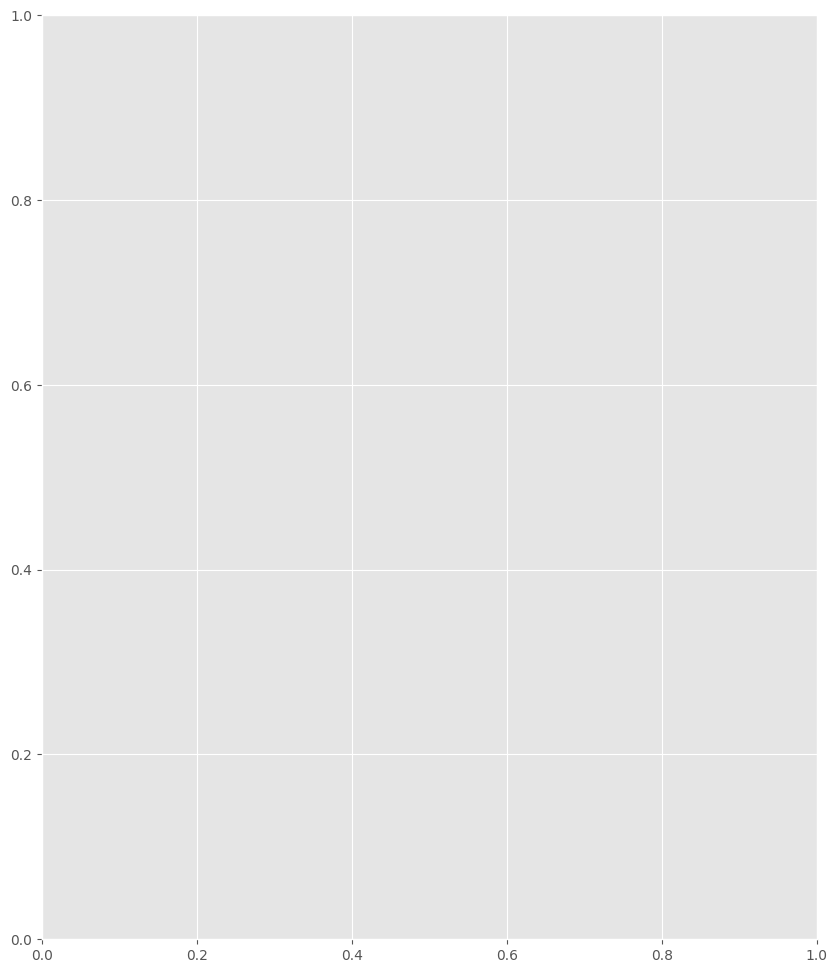

In [26]:
# 5) Query x Method hit heatmap (1 = hit, 0 = miss)
if query_method_hits.empty:
    print('No hit data available.')
else:
    hit_matrix = query_method_hits.pivot_table(
        index='query_id',
        columns='method_name',
        values='is_hit',
        aggfunc='max',
        fill_value=0
    )

    # Keep top N queries for readability in the notebook figure.
    max_queries = 40
    hit_matrix_plot = hit_matrix.head(max_queries)

    fig, ax = plt.subplots(figsize=(10, max(4, 0.3 * len(hit_matrix_plot))))
    im = ax.imshow(hit_matrix_plot.values, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)

    ax.set_title('Correct-document hit by query and method (1=hit, 0=miss)')
    ax.set_xlabel('method')
    ax.set_ylabel('query')
    ax.set_xticks(range(len(hit_matrix_plot.columns)))
    ax.set_xticklabels(hit_matrix_plot.columns, rotation=25, ha='right')
    ax.set_yticks(range(len(hit_matrix_plot.index)))
    ax.set_yticklabels(hit_matrix_plot.index)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('hit')
    plt.tight_layout()
    plt.show()

    display(hit_matrix.mean().sort_values(ascending=False).to_frame('hit_rate'))

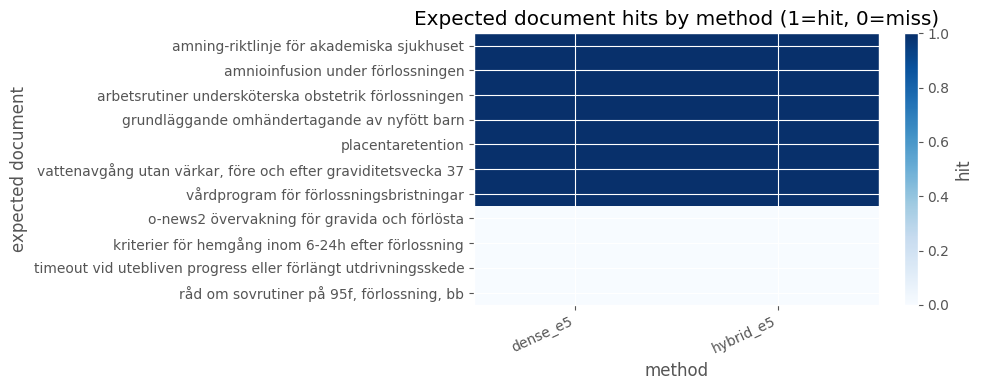

,method_name,num_expected_docs_hit
0,dense_e5,7
1,hybrid_e5,7


In [ ]:
# 6) Expected Document x Method hit matrix
doc_method_hits = run_hits.groupby(['expected_doc_id', 'method_name'], as_index=False)['is_hit'].max()
doc_method_hits = doc_method_hits[doc_method_hits['expected_doc_id'].notna() & (doc_method_hits['expected_doc_id'] != '')]

if doc_method_hits.empty:
    print('No document-level hit data available.')
else:
    doc_matrix = doc_method_hits.pivot_table(
        index='expected_doc_id',
        columns='method_name',
        values='is_hit',
        aggfunc='max',
        fill_value=0
    )

    # Sort by number of methods that hit each document.
    doc_matrix = doc_matrix.assign(_hits=doc_matrix.sum(axis=1)).sort_values('_hits', ascending=False).drop(columns=['_hits'])
    max_docs = 50
    doc_matrix_plot = doc_matrix.head(max_docs)

    fig, ax = plt.subplots(figsize=(10, max(4, 0.25 * len(doc_matrix_plot))))
    im = ax.imshow(doc_matrix_plot.values, aspect='auto', cmap='Blues', vmin=0, vmax=1)

    ax.set_title('Expected document hits by method (1=hit, 0=miss)')
    ax.set_xlabel('method')
    ax.set_ylabel('expected document')
    ax.set_xticks(range(len(doc_matrix_plot.columns)))
    ax.set_xticklabels(doc_matrix_plot.columns, rotation=25, ha='right')
    ax.set_yticks(range(len(doc_matrix_plot.index)))
    ax.set_yticklabels(doc_matrix_plot.index)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('hit')
    plt.tight_layout()
    plt.show()

doc_hit_counts = doc_method_hits.groupby('method_name', as_index=False)['is_hit'].sum().sort_values('is_hit', ascending=False)
display(doc_hit_counts.rename(columns={'is_hit': 'num_expected_docs_hit'}))